In [2]:
%load_ext autoreload
#%autoreload 2

import numpy as np
import pandas as pd
import warnings
import riskfolio as rp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize, NonlinearConstraint
#from efficientfrontier import optimize

pd.options.display.float_format = '{:.2%}'.format

In [2]:
xl = pd.ExcelFile('wartosci_walorow_12_22.xlsx')
sheets = xl.sheet_names

merged = xl.parse(sheets.pop(0))
print(sheets)

for sheet in sheets:
    data = xl.parse(sheet)    
    merged = merged.merge(data, on='Date', how='left') 

xl.close()


['MSCI ACWI', 'MWITR', 'TBSP', 'EURPLN', 'Bloomberg Barclays Euro Aggrega', 'EDO', 'Bloomberg Barclays Global Aggre', 'Gold spot price', 'Global aggregate euro hdg', 'EURO STOXX 50 Daily Leverage', 'Bloomberg Barclays Global Corpo']


In [3]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456 entries, 0 to 455
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 456 non-null    datetime64[ns]
 1   GovBondG7            456 non-null    float64       
 2   ACWI                 421 non-null    float64       
 3   Mwig40tr             156 non-null    float64       
 4   TBSP                 192 non-null    float64       
 5   EURPLN               255 non-null    float64       
 6   Euro_Corporate_Bond  164 non-null    float64       
 7   EDO                  226 non-null    float64       
 8   GlobalCorporate      124 non-null    float64       
 9   Gold                 456 non-null    float64       
 10  GABHDG               62 non-null     float64       
 11  EURO_STOXX_Leverage  253 non-null    float64       
 12  Fallen_Angels        79 non-null     float64       
dtypes: datetime64[ns](1), float64(12)
m

In [4]:
assets = merged.columns[1:]
price_changes = merged[assets].pct_change()
price_changes.set_index(merged['Date'], inplace=True)

In [5]:
price_changes.to_excel('oryginal_price_changes.xlsx')

In [6]:
euro_assets = ['ACWI', 'GovBondG7', 'GlobalCorporate', 'Gold', 'GABHDG', 'EURO_STOXX_Leverage', 'Fallen_Angels', 'Euro_Corporate_Bond']
pln_assets = ['Mwig40tr', 'TBSP', 'EDO']

pln = merged[euro_assets].apply(lambda x: x * merged['EURPLN'])
pln_chng = pln.pct_change()
pln_chng.set_index(merged['Date'], inplace=True)
pln_chng = pd.merge(price_changes[pln_assets], pln_chng, left_index=True, right_index=True)

In [7]:
#pln_chng.to_excel('pln_price_changes2.xlsx')
pln_chng.to_csv('pln_price_changes2.csv', float_format='%.3f')

In [8]:
assets = pln_chng
assets.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 456 entries, 1985-01-01 to 2022-12-01
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Mwig40tr             155 non-null    float64
 1   TBSP                 191 non-null    float64
 2   EDO                  225 non-null    float64
 3   ACWI                 254 non-null    float64
 4   GovBondG7            254 non-null    float64
 5   GlobalCorporate      123 non-null    float64
 6   Gold                 254 non-null    float64
 7   GABHDG               61 non-null     float64
 8   EURO_STOXX_Leverage  252 non-null    float64
 9   Fallen_Angels        78 non-null     float64
 10  Euro_Corporate_Bond  182 non-null    float64
dtypes: float64(11)
memory usage: 58.9 KB


In [9]:
def annullised_mean(series):
    return np.mean(series)*12

def annullised_std(series):
    return np.std(series) * np.sqrt(12)

def pstd(weights, cov_matrix):
    #variance = np.transpose(weights)@cov_matrix@weights
    variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return np.sqrt(variance)

def pmean(weightsDf, means):  
    weights = weightsDf
    return np.sum(weights * means)

def portfolioMeasures(weights,means,cov_table):
    mu = np.apply_along_axis(pmean,1,weights, means=means)
    std = np.apply_along_axis(pstd,1,weights, cov_matrix=cov_table) 
    return np.array([mu,std]).T

In [10]:
perf60 = assets.iloc[-60:].agg(['mean', np.std])
perf60.iloc[0,:] = perf60.iloc[0,:]*12
perf60.iloc[1,:] = perf60.iloc[1,:] * np.sqrt(12)
perf60

,Mwig40tr,TBSP,EDO,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels,Euro_Corporate_Bond
mean,2.32%,0.00%,4.43%,11.67%,2.38%,4.06%,11.94%,0.80%,15.18%,8.49%,3.18%
std,21.69%,5.83%,0.58%,18.02%,8.12%,9.34%,12.30%,8.55%,40.21%,12.23%,6.45%


In [11]:
perf60 = assets.loc['01-11-2017':'01-12-2021'].agg(['mean', np.std])
perf60.iloc[0,:] = perf60.iloc[0,:]*12
perf60.iloc[1,:] = perf60.iloc[1,:] * np.sqrt(12)
perf60

,Mwig40tr,TBSP,EDO,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels,Euro_Corporate_Bond
mean,3.25%,4.85%,2.89%,11.50%,2.83%,4.25%,9.31%,6.88%,14.45%,8.28%,3.73%
std,20.76%,1.76%,0.27%,16.40%,7.83%,9.16%,11.93%,6.85%,37.74%,12.19%,7.40%


In [12]:
corr60 = assets.iloc[-60:].corr(method='pearson')
#corr60 = assets.iloc[-60:].cov()
corr60.style.format("{:.2%}").background_gradient(cmap='YlGn')

,Mwig40tr,TBSP,EDO,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels,Euro_Corporate_Bond
Mwig40tr,100.00%,4.29%,1.81%,-30.80%,-41.21%,-38.10%,-22.17%,-37.96%,-17.20%,-34.14%,-36.22%
TBSP,4.29%,100.00%,-11.19%,-5.04%,-4.58%,-2.29%,6.80%,8.64%,-11.49%,4.13%,5.16%
EDO,1.81%,-11.19%,100.00%,-5.86%,-26.96%,-17.48%,-13.98%,-14.08%,7.61%,-9.33%,-4.29%
ACWI,-30.80%,-5.04%,-5.86%,100.00%,37.32%,70.60%,9.68%,57.11%,83.57%,83.90%,58.08%
GovBondG7,-41.21%,-4.58%,-26.96%,37.32%,100.00%,85.02%,47.04%,59.25%,4.40%,62.18%,49.91%
GlobalCorporate,-38.10%,-2.29%,-17.48%,70.60%,85.02%,100.00%,38.44%,66.15%,41.59%,91.47%,74.21%
Gold,-22.17%,6.80%,-13.98%,9.68%,47.04%,38.44%,100.00%,39.38%,-17.38%,30.07%,38.62%
GABHDG,-37.96%,8.64%,-14.08%,57.11%,59.25%,66.15%,39.38%,100.00%,44.68%,61.17%,59.60%
EURO_STOXX_Leverage,-17.20%,-11.49%,7.61%,83.57%,4.40%,41.59%,-17.38%,44.68%,100.00%,58.81%,38.10%
Fallen_Angels,-34.14%,4.13%,-9.33%,83.90%,62.18%,91.47%,30.07%,61.17%,58.81%,100.00%,79.44%


In [13]:
perf120 = assets.iloc[-120:].agg(['mean', np.std])
perf120.iloc[0,:] = perf120.iloc[0,:]*12
perf120.iloc[1,:] = perf120.iloc[1,:] * np.sqrt(12)
perf120

,Mwig40tr,TBSP,EDO,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels,Euro_Corporate_Bond
mean,9.26%,1.90%,3.26%,12.81%,2.56%,4.72%,5.43%,0.69%,17.54%,7.54%,3.61%
std,17.89%,4.73%,0.59%,15.21%,8.94%,9.33%,15.28%,8.48%,35.24%,11.28%,6.24%


In [14]:
corr120 = assets.iloc[-120:].corr(method='pearson')
#corr120 = assets.iloc[-120:].cov()
corr120.style.format("{:.2%}").background_gradient(cmap='YlGn')

,Mwig40tr,TBSP,EDO,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels,Euro_Corporate_Bond
Mwig40tr,100.00%,4.09%,-2.53%,-26.05%,-35.52%,-34.43%,-29.45%,-37.71%,-13.60%,-29.83%,-34.89%
TBSP,4.09%,100.00%,-12.85%,-9.22%,-15.34%,-12.34%,-7.32%,8.52%,-9.96%,-0.25%,-8.71%
EDO,-2.53%,-12.85%,100.00%,-2.09%,-14.90%,-10.80%,-5.09%,-13.41%,5.30%,-4.69%,-1.60%
ACWI,-26.05%,-9.22%,-2.09%,100.00%,40.48%,69.42%,16.35%,57.15%,81.87%,84.21%,59.96%
GovBondG7,-35.52%,-15.34%,-14.90%,40.48%,100.00%,89.02%,55.72%,59.24%,8.83%,64.17%,63.96%
GlobalCorporate,-34.43%,-12.34%,-10.80%,69.42%,89.02%,100.00%,47.14%,66.16%,40.62%,91.53%,78.61%
Gold,-29.45%,-7.32%,-5.09%,16.35%,55.72%,47.14%,100.00%,39.48%,-4.66%,32.20%,38.59%
GABHDG,-37.71%,8.52%,-13.41%,57.15%,59.24%,66.16%,39.48%,100.00%,44.77%,61.19%,59.59%
EURO_STOXX_Leverage,-13.60%,-9.96%,5.30%,81.87%,8.83%,40.62%,-4.66%,44.77%,100.00%,59.90%,39.18%
Fallen_Angels,-29.83%,-0.25%,-4.69%,84.21%,64.17%,91.53%,32.20%,61.19%,59.90%,100.00%,78.72%


In [15]:
perf180 = assets.iloc[-180:].agg(['mean', np.std])
perf180.iloc[0,:] = perf180.iloc[0,:]*12
perf180.iloc[1,:] = perf180.iloc[1,:] * np.sqrt(12)
perf180

,Mwig40tr,TBSP,EDO,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels,Euro_Corporate_Bond
mean,8.57%,3.68%,3.70%,10.39%,5.49%,4.44%,10.78%,0.69%,8.80%,7.54%,5.44%
std,17.52%,4.39%,0.52%,15.81%,11.75%,9.25%,18.95%,8.48%,38.29%,11.28%,8.21%


In [16]:
corr180 = assets.iloc[-180:].corr(method='pearson')
#corr120 = assets.iloc[-120:].cov()
corr180.style.format("{:.2%}").background_gradient(cmap='YlGn')

,Mwig40tr,TBSP,EDO,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels,Euro_Corporate_Bond
Mwig40tr,100.00%,7.45%,-2.32%,-29.76%,-39.56%,-34.82%,-26.15%,-37.71%,-15.19%,-29.83%,-44.63%
TBSP,7.45%,100.00%,-2.82%,-8.63%,-7.83%,-13.38%,-2.15%,8.52%,-9.10%,-0.25%,-6.39%
EDO,-2.32%,-2.82%,100.00%,-0.40%,-4.23%,-11.51%,1.38%,-13.41%,3.62%,-4.69%,5.87%
ACWI,-29.76%,-8.63%,-0.40%,100.00%,22.71%,69.42%,11.88%,57.15%,79.96%,84.21%,54.67%
GovBondG7,-39.56%,-7.83%,-4.23%,22.71%,100.00%,88.76%,58.02%,59.24%,-17.37%,64.17%,61.35%
GlobalCorporate,-34.82%,-13.38%,-11.51%,69.42%,88.76%,100.00%,47.66%,66.16%,40.27%,91.53%,78.39%
Gold,-26.15%,-2.15%,1.38%,11.88%,58.02%,47.66%,100.00%,39.48%,-18.20%,32.20%,45.13%
GABHDG,-37.71%,8.52%,-13.41%,57.15%,59.24%,66.16%,39.48%,100.00%,44.77%,61.19%,59.59%
EURO_STOXX_Leverage,-15.19%,-9.10%,3.62%,79.96%,-17.37%,40.27%,-18.20%,44.77%,100.00%,59.90%,28.82%
Fallen_Angels,-29.83%,-0.25%,-4.69%,84.21%,64.17%,91.53%,32.20%,61.19%,59.90%,100.00%,78.72%


In [17]:
perf180 = assets.loc['01-01-2005':'01-12-2022'].agg(['mean', np.std])
perf180.iloc[0,:] = perf180.iloc[0,:]*12
perf180.iloc[1,:] = perf180.iloc[1,:] * np.sqrt(12)
perf180

,Mwig40tr,TBSP,EDO,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels,Euro_Corporate_Bond
mean,10.83%,4.11%,3.41%,10.79%,4.75%,5.77%,11.70%,4.00%,12.62%,9.56%,5.36%
std,16.97%,3.28%,0.38%,15.00%,11.57%,9.06%,18.76%,7.23%,35.28%,10.89%,8.51%


In [18]:
corr180 = assets.loc['01-01-2005':'01-12-2022'].corr(method='pearson')
#corr120 = assets.iloc[-120:].cov()
corr180.style.format("{:.2%}").background_gradient(cmap='YlGn')

,Mwig40tr,TBSP,EDO,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels,Euro_Corporate_Bond
Mwig40tr,100.00%,-5.37%,4.23%,-29.37%,-41.44%,-36.76%,-27.97%,-51.38%,-15.42%,-29.35%,-48.57%
TBSP,-5.37%,100.00%,5.10%,-5.89%,-9.34%,-18.30%,-5.15%,21.66%,-1.41%,0.63%,-9.39%
EDO,4.23%,5.10%,100.00%,6.35%,4.66%,-3.13%,6.62%,-5.74%,3.03%,10.38%,12.13%
ACWI,-29.37%,-5.89%,6.35%,100.00%,23.51%,65.74%,17.47%,46.79%,79.29%,82.74%,59.01%
GovBondG7,-41.44%,-9.34%,4.66%,23.51%,100.00%,87.64%,57.05%,57.53%,-18.76%,56.98%,62.55%
GlobalCorporate,-36.76%,-18.30%,-3.13%,65.74%,87.64%,100.00%,52.19%,64.36%,36.03%,90.84%,83.28%
Gold,-27.97%,-5.15%,6.62%,17.47%,57.05%,52.19%,100.00%,58.87%,-13.55%,36.50%,45.76%
GABHDG,-51.38%,21.66%,-5.74%,46.79%,57.53%,64.36%,58.87%,100.00%,29.39%,60.89%,75.57%
EURO_STOXX_Leverage,-15.42%,-1.41%,3.03%,79.29%,-18.76%,36.03%,-13.55%,29.39%,100.00%,58.70%,30.58%
Fallen_Angels,-29.35%,0.63%,10.38%,82.74%,56.98%,90.84%,36.50%,60.89%,58.70%,100.00%,87.56%


<AxesSubplot:xlabel='Date'>

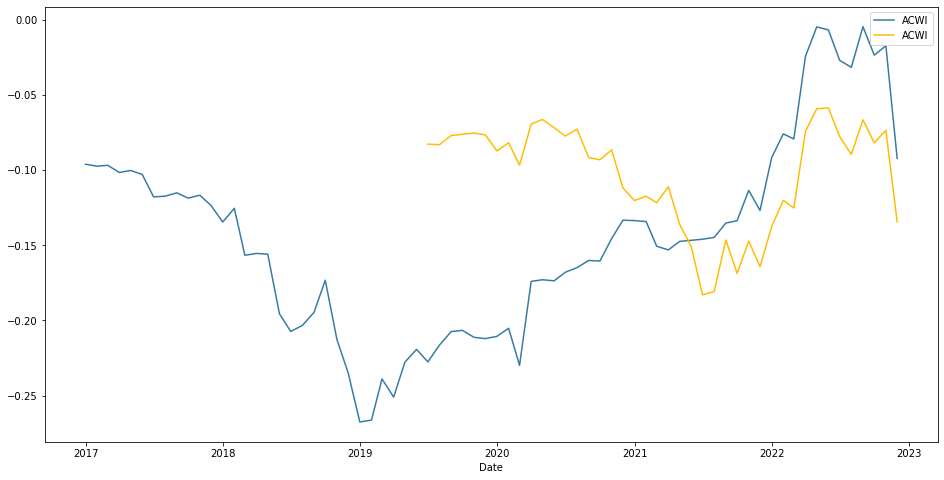

In [19]:
moving_corr = assets[['ACWI']].rolling(120).corr(assets['TBSP'])
moving_corr60 = assets[['ACWI']].rolling(150).corr(assets['TBSP'])
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=moving_corr, ax=ax, palette='mako')
sns.lineplot(data=moving_corr60, ax=ax, palette='Wistia_r')

In [20]:
portfolio_assets = assets[['Mwig40tr', 'TBSP', 'ACWI', 'Gold', 'EURO_STOXX_Leverage', 'EDO']]
means = pd.DataFrame(portfolio_assets.mean()*12)
cov = pd.DataFrame(portfolio_assets.cov())


In [40]:
#assets ['Mwig40tr', 'TBSP', 'ACWI', 'GovBondG7', 'GlobalCorporate', 'Gold', 'GABHDG', 'EURO_STOXX_Leverage', 'Fallen_Angels', 'EDO']
#['Mwig40tr', 'TBSP', 'ACWI', 'Gold', 'GovBondG7', 'EDO]

porfolio_assets = assets[['Mwig40tr', 'TBSP', 'ACWI', 'Gold', 'Euro_Corporate_Bond']]
port = rp.Portfolio(porfolio_assets[-150:])



means = pd.DataFrame(portfolio_assets['01-01-2004':'01-12-2022'].mean()*12)
cov = pd.DataFrame(portfolio_assets['01-01-2004':'01-12-2022'].cov())

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

points = 10 # Number of points of the frontier
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm =  'MDD' #'MV' vs 'MDD' # Risk measure used, this time will be variance
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0.00 # Risk free rate

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)


display(frontier.T.head(50))




,Mwig40tr,TBSP,ACWI,Gold,Euro_Corporate_Bond
0,3.65%,25.92%,10.37%,13.94%,46.11%
1,15.15%,13.03%,27.55%,29.89%,14.38%
2,22.12%,2.70%,38.74%,36.44%,0.00%
3,7.22%,0.00%,54.49%,38.29%,0.00%
4,0.00%,0.00%,65.86%,34.14%,0.00%
5,0.00%,0.00%,73.43%,26.57%,0.00%
6,0.00%,0.00%,81.00%,19.00%,0.00%
7,0.00%,0.00%,87.58%,12.42%,0.00%
8,0.00%,0.00%,93.79%,6.21%,0.00%
9,0.00%,0.00%,100.00%,0.00%,0.00%


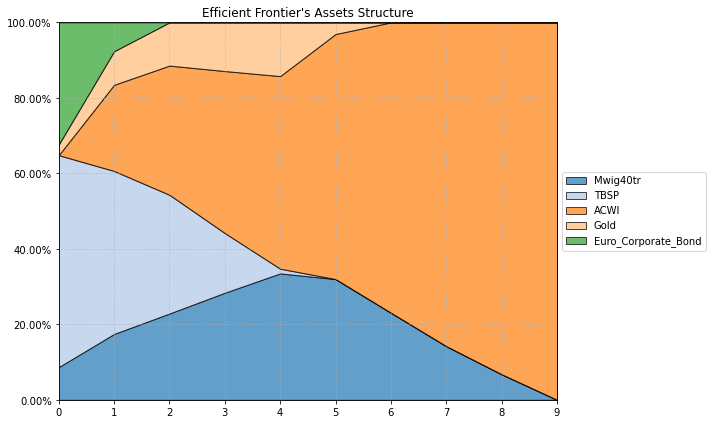

In [39]:
ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

In [23]:
porfolio_assets[-150:].cov().to_numpy()
frontier.values.T
porfolio_assets[-150:].mean().values.T*12

array([0.0838378 , 0.03067022, 0.12365509, 0.06559336, 0.02720226,
       0.03527836])

In [37]:
measures = portfolioMeasures(frontier.values.T,porfolio_assets[-150:].mean().values.T, porfolio_assets[-150:].cov().to_numpy())
measures[:,0] = measures[:,0]*12
measures[:,1] = measures[:,1]*np.sqrt(12)

measures

array([[0.48159909, 0.10904285],
       [0.59776228, 0.11744235],
       [0.65124742, 0.1258418 ],
       [0.69439265, 0.13424127],
       [0.73246961, 0.14264075],
       [0.76747111, 0.15104022],
       [0.80039418, 0.15943971],
       [0.83181601, 0.16783917],
       [0.86210333, 0.17623863],
       [0.8914099 , 0.18463815],
       [0.91957286, 0.1930376 ],
       [0.94680148, 0.20143709],
       [0.9732807 , 0.20983659],
       [0.9991461 , 0.21823601],
       [1.02450071, 0.22663549],
       [1.04942391, 0.23503497],
       [1.07397849, 0.24343443],
       [1.09821509, 0.25183392],
       [1.1221747 , 0.26023336],
       [1.14589163, 0.26863287],
       [1.16939388, 0.2770323 ],
       [1.1927057 , 0.28543177],
       [1.21584748, 0.29383131],
       [1.23789155, 0.30223073],
       [1.25725148, 0.31063021],
       [1.27478792, 0.3190297 ],
       [1.29103194, 0.32742914],
       [1.30630497, 0.33582861],
       [1.32081828, 0.34422808],
       [1.33471205, 0.35262757],
       [1.

In [31]:
import numpy as np
from scipy.optimize import minimize, NonlinearConstraint

def pstd(weights, cov_matrix):
    #variance = np.transpose(weights)@cov_matrix@weights
    variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return np.sqrt(variance)*np.sqrt(12)

def pmean(weightsDf, means):  
    weights = weightsDf
    return weights.dot(means) *12



def optimize(expectedMean, means: np.array, cov_table: np.array):

    constraint1 = NonlinearConstraint(lambda x : x.sum(),1,1)
    constraint2 = NonlinearConstraint(lambda x: x.dot(means)*12, expectedMean, expectedMean)
    constraint3 = NonlinearConstraint(lambda x: np.all(np.any([x >=0.05, x == 0], axis=0)),True,True)
    assets_contraints = [(0,1), (0,1),(0,1),(0,1),(0,0.1)]
    bounds = [(0,1) for n in range(len(means))]

    #obj = lambda x: x.T@cov_table@x
    obj = lambda x: np.dot(x.T, np.dot(cov_table, x))
    start = [1/len(means) for n in range(len(means))]
    result = minimize(obj,start,constraints=[constraint1, constraint2],bounds=assets_contraints)
    #result = np.append(result.x, [expectedMean], [result.fun])    

    return np.array(result.x)


In [26]:

#assets ['Mwig40tr', 'TBSP', 'ACWI', 'GovBondG7', 'GlobalCorporate', 'Gold', 'GABHDG', 'EURO_STOXX_Leverage', 'Fallen_Angels', 'EDO' ]

assets_names = ['Mwig40tr', 'TBSP', 'Euro_Corporate_Bond', 'ACWI', 'Gold', ]

#portfolio = assets.iloc[-60:][assets_names]
portfolio = price_changes.iloc[-150:][assets_names]
means = portfolio.mean()
cov_table = portfolio.cov()
stds = portfolio.std()


print(means*12)
print(cov_table)
print(stds*np.sqrt(12))


Mwig40tr               8.38%
TBSP                   3.07%
Euro_Corporate_Bond    3.19%
ACWI                  10.94%
Gold                   5.32%
dtype: float64
                     Mwig40tr   TBSP  Euro_Corporate_Bond   ACWI   Gold
Mwig40tr                0.26%  0.00%               -0.00% -0.01% -0.02%
TBSP                    0.00%  0.02%                0.00% -0.00% -0.00%
Euro_Corporate_Bond    -0.00%  0.00%                0.01%  0.02%  0.01%
ACWI                   -0.01% -0.00%                0.02%  0.13% -0.00%
Gold                   -0.02% -0.00%                0.01% -0.00%  0.20%
Mwig40tr              17.63%
TBSP                   4.40%
Euro_Corporate_Bond    3.69%
ACWI                  12.60%
Gold                  15.42%
dtype: float64


In [30]:
mu_min = 0.0307 #means.min()*12
mu_max = 0.1094

portfolio_means = np.linspace(mu_min, mu_max, 10)


weights = np.empty((0,len(assets_names)+2))
for mean in portfolio_means:
    weight = optimize(mean,means,cov_table)
    std = pstd(weight,cov_table)
    weight = np.append(weight, [mean, std])
    weights = np.append(weights, [weight], axis=0)

columns = np.append(assets_names, ['mu', 'std'])
porfolios = pd.DataFrame(weights, columns=columns) 

porfolios



,Mwig40tr,TBSP,Euro_Corporate_Bond,ACWI,Gold,mu,std
0,0.00%,97.53%,2.47%,0.00%,0.00%,3.07%,4.30%
1,12.22%,40.21%,39.57%,0.00%,8.00%,3.94%,3.47%
2,16.52%,33.79%,33.40%,8.29%,8.00%,4.82%,3.97%
3,20.30%,27.46%,27.30%,16.94%,8.00%,5.69%,4.70%
4,24.08%,21.14%,21.20%,25.58%,8.00%,6.57%,5.60%
5,27.86%,14.81%,15.10%,34.23%,8.00%,7.44%,6.59%
6,31.91%,8.92%,9.43%,43.06%,6.67%,8.32%,7.69%
7,36.02%,3.12%,3.86%,51.94%,5.07%,9.19%,8.84%
8,34.27%,0.00%,0.00%,65.73%,0.00%,10.07%,9.92%
9,0.09%,0.00%,0.00%,99.91%,0.00%,10.94%,12.59%


In [28]:
minimal_weights = lambda x: (np.any([x >=0.05, x == 0])).sum()

wc = np.array([1, 0.051, 0.5, 0.06])

minimal_weights(wc)

1

In [29]:
from investment_planner import WMin,WMax, deductE 

infusions = [0,0,0,0]
minMean = 0.0526
minStd = 0.0374
maxMean = 0.0886
maxStd = 0.1954
t=1
W0=100
goals = np.array([0,0,0,0])
Wmin = 1

wmin = WMin(t,W0,infusions,goals,minMean,minStd,maxStd)
wmin = Wmin if wmin < Wmin else wmin
wmax = WMax(t,W0,infusions,maxMean,minStd, maxStd)

row = np.linspace(np.log(wmin),np.log(wmax),8)

row = deductE(row, np.log(W0))

np.exp(row)





IndentationError: expected an indented block (investment_planner.py, line 77)

[[ 63.3121,  73.7323,  85.8675, 100.    , 116.4585, 135.6257,
        157.9477, 183.9434],
       [  0.816 ,   1.8186,   4.053 ,   9.033 ,  20.1321,  44.8689,
        100.    , 222.8717]])
 y: array([[ 63.3121,  73.7323,  85.8675, 100.    , 116.4585, 135.6257,
        157.9477, 183.9434],
       [  0.7689,   1.7306,   3.8955,   8.7684,  19.737 ,  44.4264,
        100.    , 225.0916]])

c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


87.20754951637974

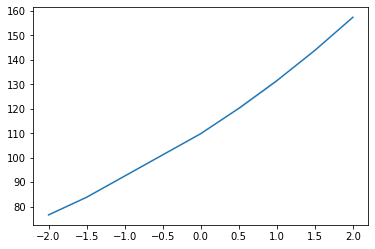

In [ ]:
mean = 0.11
std = 0.18
W0 = 100
t = 1
z = 0

W = lambda z: W0*np.exp((mean - (std*std)/2)*t+std*np.sqrt(t)*z)

x = [-2,-1.5,1,0.5,0,0.5,1,1.5,2]
y = [W(z) for z in x]

sns.lineplot(x,y)

W(-1.2815515655446004)


-6.907755278982137